### Two-point correlation functions for shear and convergence in DC2

In this notebook, we compute two-point correlation functions for shear and convergence using a catalog of DC2 galaxies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import lognorm

import treecorr
import pyccl

### Load data

We load the full DC2 catalog and then create a random subset of ten million galaxies to reduce the computational demand of the calculations below.

In [2]:
# This cell takes 3-5 minutes
catalog = pd.read_csv("/data/scratch/shreyasc/cosmo_only.csv")

In [3]:
# This cell takes 5-10 seconds
catalog_subset = catalog.sample(n = 10000000)

### Empirical two-point correlations using `treecorr`

In [4]:
cat = treecorr.Catalog(ra = catalog_subset["ra"], dec = catalog_subset["dec"], ra_units = "deg", dec_units = "deg",
                       g1 = catalog_subset["shear_1"], g2 = catalog_subset["shear_2"], k = catalog_subset["convergence"])

#### Shear

In [5]:
# This cell takes less than a minute
gg = treecorr.GGCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
gg.process(cat)

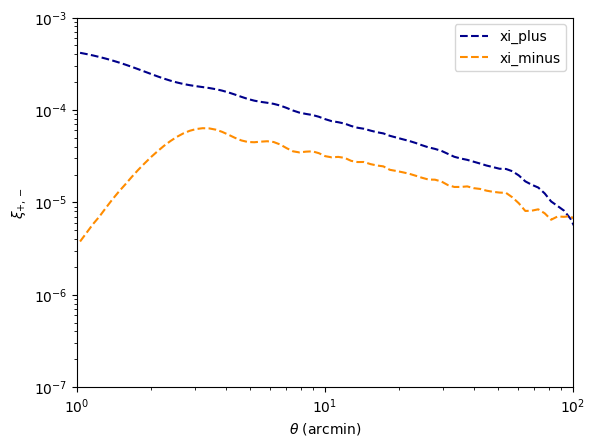

In [6]:
r = np.exp(gg.meanlogr)
xip = gg.xip
xim = gg.xim

_ = plt.plot(r, xip, color = 'darkblue', linestyle = '--', label = 'xi_plus')
_ = plt.plot(r, xim, color = 'darkorange', linestyle = '--', label = 'xi_minus')
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

#### Convergence

In [7]:
# This cell takes less than a minute
kk = treecorr.KKCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
kk.process(cat)

We confirm that the two-point correlation function of the convergence is identical to $\xi_+$ for shear as the number of galaxies in the sample $\rightarrow \infty$ (see, e.g., Kilbinger 2015 sec 3.8). The discrepancy for larger $\theta$ in the plot below is due to the fact that we are using a finite sample.

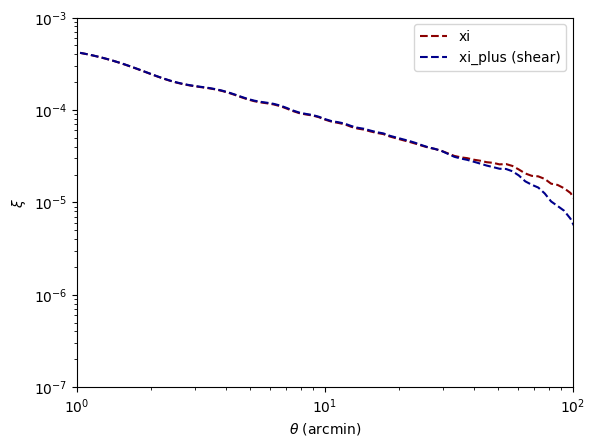

In [8]:
r = np.exp(kk.meanlogr)
xi = kk.xi

_ = plt.plot(r, xi, color = 'darkred', linestyle = '--', label = 'xi')
_ = plt.plot(r, xip, color = 'darkblue', linestyle = '--', label = 'xi_plus (shear)')
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

### Theoretical two-point correlations using `pyccl`

The assumed cosmology for CosmoDC2 is close to the best fitting parameters from WMAP-7 (see TXPipe paper).

In [9]:
wmap7_cosmo = pyccl.cosmology.Cosmology(Omega_c = 0.22,
                                        Omega_b = 0.048,
                                        h = 0.71,
                                        n_s = 0.963,
                                        sigma8 = 0.8)

We model the redshift distribution with a lognormal pdf. The intent here is to match the empirical redshift distribution of our sample of ten million CosmoDC2 galaxies. If we get close, then the theoretical two-point correlation function should be pretty close to the empirical version we estimated above.

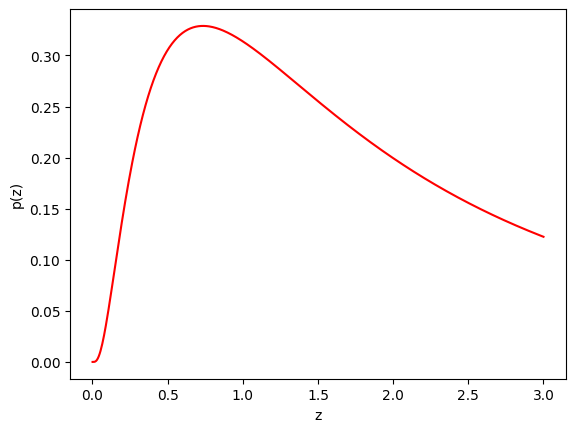

In [10]:
z = np.linspace(0.001, 3, 512)
n = lognorm.pdf(z, 1, scale = 2)

_ = plt.plot(z, n, color = 'red')
_ = plt.xlabel('z')
_ = plt.ylabel('p(z)')

We create a weak lensing tracer using the above cosmology and redshift distribution, and then we compute the angular power spectrum, which is the harmonic-space equivalent of the two-point correlation function.

In [11]:
lensing_tracer = pyccl.WeakLensingTracer(wmap7_cosmo, dndz=(z, n))

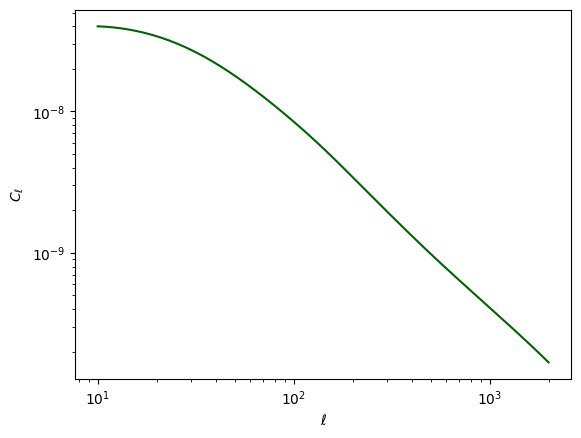

In [12]:
ell = np.arange(10, 2000)
cl = pyccl.angular_cl(wmap7_cosmo, lensing_tracer, lensing_tracer, ell)

_ = plt.plot(ell, cl, color = 'darkgreen')
_ = plt.xlabel('$\ell$')
_ = plt.ylabel('$C_\ell$')
_ = plt.xscale('log')
_ = plt.yscale('log')

And finally, we use the angular power spectrum to compute the two-point correlation function $\xi_{+,-}$.

In [13]:
theta_degrees = r/60  # 1 degree is 60 arcmins

xip_theory = pyccl.correlation(cosmo = wmap7_cosmo,
                               ell = ell, C_ell = cl,
                               theta = theta_degrees, type = 'GG+')
xim_theory = pyccl.correlation(cosmo = wmap7_cosmo,
                               ell = ell, C_ell = cl,
                               theta = theta_degrees, type = 'GG-')

We find that the theoretical correlation function is pretty close to the empirical DC2 correlation function. The most likely source of the discrepancy is the redshift distribution, since we did not use the redshifts of the DC2 galaxies to inform our theoretical redshift distribution.

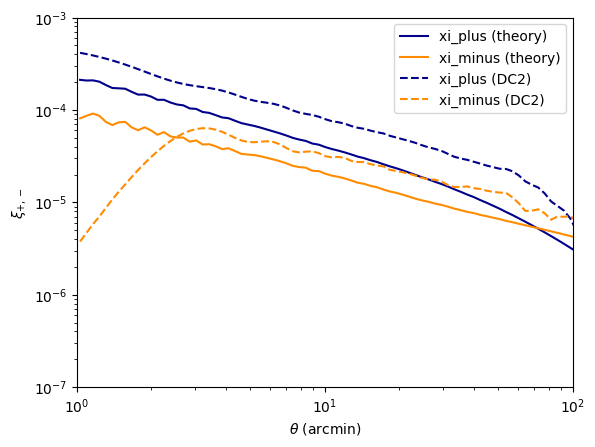

In [14]:
_ = plt.plot(60 * theta_degrees, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(60 * theta_degrees, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.plot(r, xip, color = 'darkblue', linestyle = '--', label = "xi_plus (DC2)")
_ = plt.plot(r, xim, color = 'darkorange', linestyle = '--', label = "xi_minus (DC2)")
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])